# ASSIGNMENT ONE


### first load the module and several packages

In [1]:
include("../code/LocalMethods.jl")
using .LocalMethods
using CSV
using DataFrames
using PyPlot
using LinearAlgebra
using Statistics
using Random
using StatsBase
using Distributions
using BenchmarkTools
using LinearAlgebra

Then we load the data in my local path 

In [2]:
data_file = "../data/UStmax.csv"
csv_data  = CSV.File(data_file)
df        = DataFrame!(csv_data)  # puts it into a data DataFrame



,lat,lon,elev,UStmax
,Float64,Float64,Float64,Float64
1,32.95,-85.95,201.0,33.1333
2,33.15,-88.13,49.0,32.2
3,31.32,-86.5,107.0,33.6
4,33.58,-85.85,184.0,32.6333
5,33.27,-85.83,308.0,31.8333
6,31.17,-87.48,92.0,33.3333
7,32.6,-85.5,223.0,32.7667
8,33.45,-87.35,85.0,33.7
9,34.7,-86.88,183.0,32.5


we extract global mean temperature and remove a random set of data. 
Also, we randomly select 10% data for test

In [3]:
mean_temp = mean(df.UStmax)
df.UStmax = df.UStmax.-mean_temp
#n equals the number of sample data
n = length(df.lat)
#n1 equals the number of test data
n1 = floor(0.1*n) |>Int

440

In [5]:
Test_sample = sort(sample(1:n,n1,replace=false))
Train_sample=setdiff(1:n,Test_sample)

#using Train_Data to store the Training Data
Train_Data=df[Train_sample,:]
#using Test_Data to store the Testing Data
Test_Data=df[Test_sample,:]
Train_data=df[Train_sample,4]
Test_data=df[Test_sample,4]


440-element Array{Float64,1}:
  3.2425892316999025 
  4.075922565033302  
  2.9092558983666024 
  5.409255898366602  
  2.7759225650333015 
  3.809255898366601  
  8.9759225650333    
 -0.6574107683000996 
  9.2092558983666    
  3.4092558983666024 
  4.5425892316999    
 -2.1240774349667007 
 11.609255898366598  
  ⋮                  
 -1.0907441016333976 
 -1.9907441016333998 
 -5.2574107683000975 
  0.07592256503330219
 -4.2240774349666985 
 -1.7240774349666985 
 -4.624077434966701  
 -0.05741076830009817
  1.0759225650333022 
 -0.49074410163339977
  0.6092558983666017 
 -0.22407743496669852

## Matern Covariance

### find the suitable parameter for Matern covariance

I use the parameter grid and estimate the likelihood for each combination of parameter 
$$\upsilon\_ set=0.5:1:4.5\\
\rho\_ set=0.25:0.25:2\\
\sigma\_ set= 1:5  $$
And using the likelihood 
\begin{align*}
\log P(\mathbf{z}|\theta)&=-\frac{1}{2}(\mathbf{z}-\mu)^T\Sigma^{-1}(\mathbf{z}-\mu)-\frac{1}{2}\log|\Sigma_{\theta } |+const \\
   &=-\frac{1}{2} \left\| \mathbf{L}_{\theta}^{-1}(\mathbf{z}-\mu)  \right\|^2- \sum_{i=1}^n\log \mathbf{L}_{\theta}[i,i] +const
\end{align*}
where $\mathbf{z}$ is the training data, $\Sigma$ is the covariance function of training data.  $\mathbf{L}_\theta$ is the cholesky decomposition of $\Sigma$
So, for each pair of the parameters in the grid, we can use the training data to calculate the likelihood. And the We can find out the parameter with the maximum likelihood value. 




In [6]:
nrm = sqrt.((df.lon .- df.lon').^2 .+ (df.lat .- df.lat').^2)
nrm_train = nrm[Train_sample,Train_sample]


# set the grid of trhe parameter
ν_set = 0.5:1:4.5
ρ_set = 0.25:0.25:2
σ_set = 1:5




#We use the training data and calculate the likelihood for each parameter
function choosing_parameter(ν_set,ρ_set,σ,nrm_train,Train_data)
     n1 = length(ν_set)
	 n2 = length(ρ_set)
	 A = zeros(n1,n2)
	 for i = 1:n1
		 for j = 1:n2
			 ΣX = M_νρσ.(nrm_train; ν=ν_set[i], ρ=ρ_set[j], σ=σ) |> Symmetric
			 ch = cholesky(ΣX)
			 #log likelihood of the parameter
			 A[i,j] = -1/2* norm((ch.L \Train_data),2 )^2- sum(log.( diag(ch.L)   ))
		 end
	 end
    #we want to find the maximum of these likelihood 
	 index = findmax(A)[2]
	 ν_max = index[1]
	 ρ_max = index[2]
     return [ν_max,ρ_max,A[ν_max,ρ_max]]

 end






choosing_parameter (generic function with 1 method)

In [6]:
choosing_parameter(ν_set,ρ_set,σ_set[1],nrm_train,Train_data)
choosing_parameter(ν_set,ρ_set,σ_set[2],nrm_train,Train_data)
choosing_parameter(ν_set,ρ_set,σ_set[3],nrm_train,Train_data)
choosing_parameter(ν_set,ρ_set,σ_set[4],nrm_train,Train_data)
choosing_parameter(ν_set,ρ_set,σ_set[5],nrm_train,Train_data)

3-element Array{Float64,1}:
      1.0          
      2.0          
 -16758.52530351989


### Using the grid search method to find the best parameter for matern covariance
υ=0.5 
ρ=1.25 
σ=4
we can make some prediction using these parameters
Fix the parameter of Matern Covariance function, we can easily calculate the covariance matrix of the whole dataset. 
And then we use Conditional Gaussian Distribution to make the prediction 
$$
\mathbf{y}|(z) \sim \mathcal{N} ( \Sigma_{01}\Sigma_{11}^{-1}(\mathbf{z}-\mu_z)+\mu_y , \Sigma_{00}-\Sigma_{01}\Sigma_{11}^{-1}\Sigma_{10} )
$$
where y is the prediction data, z is the training data. and the distribution of (y,z) is 
$$
\begin{pmatrix}
y\\
z 
\end{pmatrix}
\sim \mathcal{N} 
\begin{pmatrix}
   \begin{pmatrix}
      \mu_y\\
      \mu_z
   \end{pmatrix}
   , 
   \begin{pmatrix}
       \Sigma_{00} & \Sigma_{01}\\
       \Sigma_{10} & \Sigma_{11}
    \end{pmatrix}
\end{pmatrix}
$$


In [7]:
υ = 0.5
ρ = 1.25
σ = 4
 
nrm = sqrt.((df.lon .- df.lon').^2 .+ (df.lat .- df.lat').^2)
Σ = M_νρσ.(nrm; ν=υ, ρ=ρ, σ=σ) |> Symmetric
#whiten the data and Σ to reduce the dynamic range

ΣX = Σ[Train_sample,Train_sample]
ΣY = Σ[Test_sample,Test_sample]
ΣXY = Σ[Train_sample,Test_sample]
# conditional normal distribution
μy_x = ΣXY'*(ΣX\Train_data)
Σy_x = ΣY-ΣXY'*(ΣX\ΣXY) |>Symmetric


#prediction
Pred_Mat = rand(MvNormal(μy_x,Σy_x),1)


440×1 Array{Float64,2}:
   6.5908980739012515
  -1.44109401698495  
   2.078558746291998 
   5.905164561639753 
   4.962578118913859 
   5.295455460213586 
   4.921891302230414 
   1.6629681882915226
  11.019665105812038 
   7.199707436586076 
   5.6256104151462045
  -3.153411329854176 
   9.76300345380555  
   ⋮                 
  -4.732123985629393 
  -2.2660573901691685
 -10.226393771618842 
   1.0857291629690022
 -10.431464582641146 
  -4.375806010370486 
  -6.421500450245649 
  -1.2358224894564218
   0.3231428479596243
   4.198024753614607 
  -1.620769223159832 
   1.933788712407197 

MSE of prediction under matern covariance 
and proportion of the deviation 

In [8]:
norm(Test_data - Pred_Mat) ^ 2 / n1

8.11891644075021

In [9]:
norm(Test_data - Pred_Mat) / norm(Test_data)

0.6870141643358073

we can draw the histogram of the residuals 

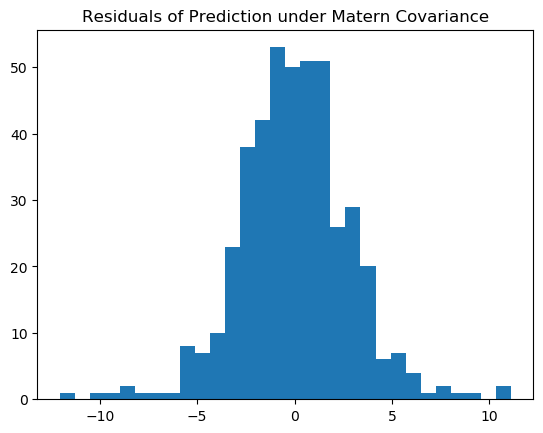

PyObject Text(0.5, 1, 'Residuals of Prediction under Matern Covariance')

In [10]:
residuals_mat = Test_data - Pred_Mat
plt.hist(residuals_mat, 30, )
PyPlot.title("Residuals of Prediction under Matern Covariance")

If we normailize the residual we can get another histogram

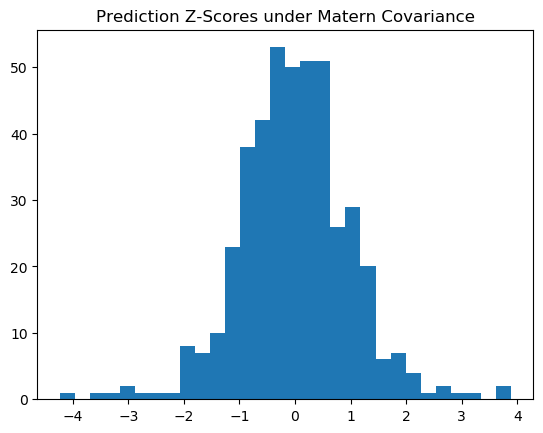

PyObject Text(0.5, 1, 'Prediction Z-Scores under Matern Covariance')

In [11]:
plt.hist((residuals_mat .- mean(residuals_mat)) ./ std(residuals_mat),30)
PyPlot.title("Prediction Z-Scores under Matern Covariance")

### Prediction uncertainty quantification for matern covariance model.


Point-wise uncertainty quantification 

In [12]:
c1=sum(abs.(Test_data).>σ)  / n1
c2=sum(abs.(Test_data).>2σ) / n1
c3=sum(abs.(Test_data).>3σ) / n1
[c1,c2,c3]

3-element Array{Float64,1}:
 0.3340909090909091   
 0.06136363636363636  
 0.0022727272727272726

The result shows that N(0, Σy_x ) is a good fit for Test_data
Which means that we do a good prediction using matern covariance 

### Draw the scatter plot of the prediction data 


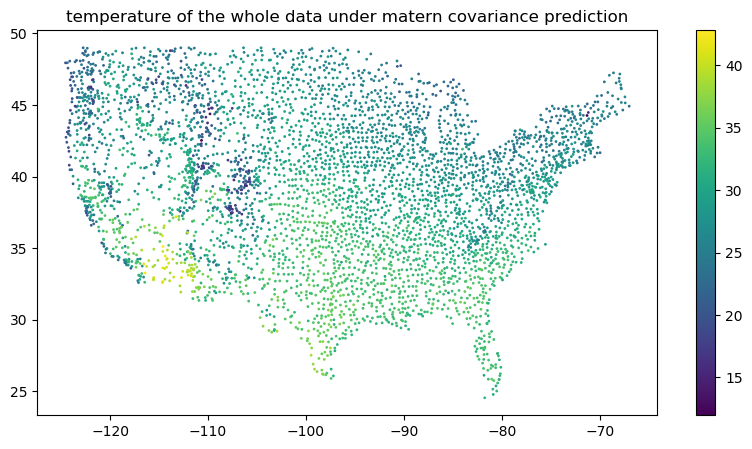

PyObject <matplotlib.colorbar.Colorbar object at 0x1737ee2b0>

In [13]:
df_mat = df
df_mat[Test_sample,4] = Pred_Mat[:,1]
figure(figsize = (10,5))
scatter(df_mat.lon, df_mat.lat, c = df_mat.UStmax .+ mean_temp, s = 1)
title("temperature of the whole data under matern covariance prediction")
colorbar()


Compare with the original data

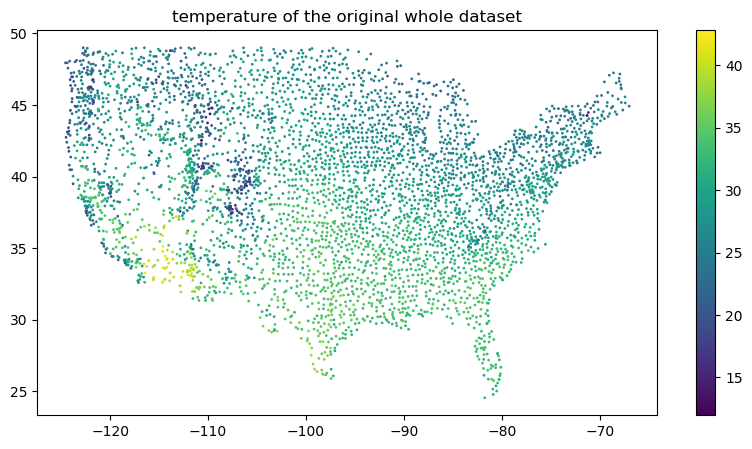

PyObject <matplotlib.colorbar.Colorbar object at 0x173a32a90>

In [14]:
figure(figsize = (10,5))
scatter(df.lon, df.lat, c = df.UStmax .+ mean_temp, s = 1)
title("temperature of the original whole dataset")
colorbar()

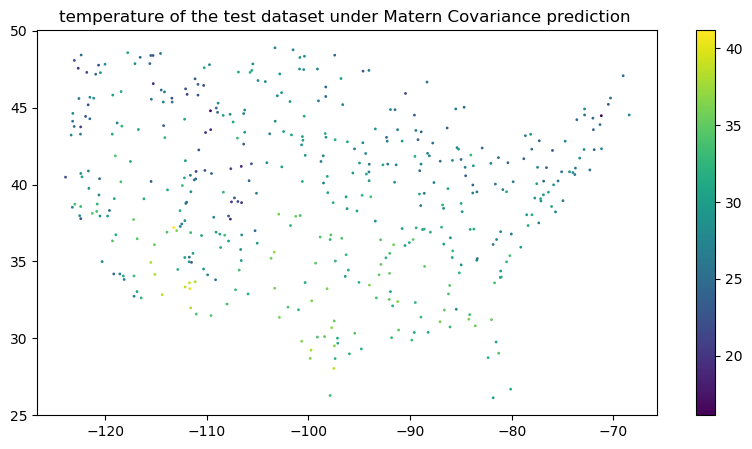

PyObject <matplotlib.colorbar.Colorbar object at 0x1738d1f60>

In [15]:
figure(figsize = (10,5))
scatter(Test_Data.lon, Test_Data.lat, c = Pred_Mat[:,1] .+ mean_temp, s = 1)
title("temperature of the test dataset under Matern Covariance prediction ")
colorbar()

Compare with the originl data

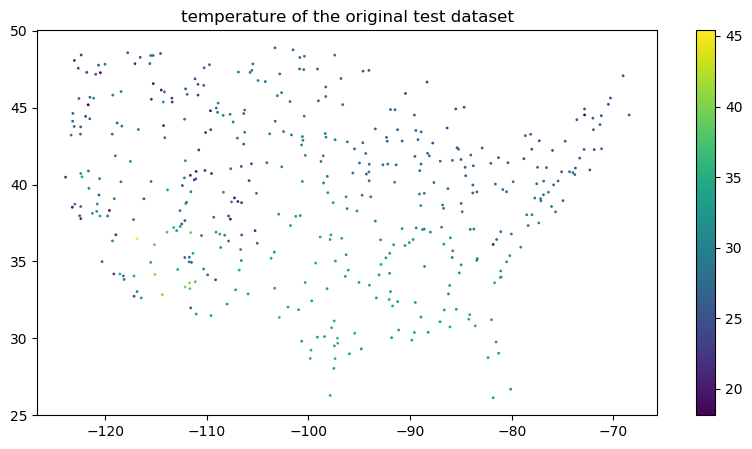

PyObject <matplotlib.colorbar.Colorbar object at 0x173e412b0>

In [16]:
figure(figsize = (10,5))
scatter(Test_Data.lon, Test_Data.lat, c = Test_Data.UStmax .+ mean_temp, s = 1)
title("temperature of the original test dataset")
colorbar()

## Gaussian Autocovariance Model 

In Gaussian Autocavariance model, we use the grid net to select the parameter 
After some original tests, we select parameter in the following parameter sets
$$
\rho\_set= 0.1:0.1:0.5\\
\sigma\_set=1:4
$$


In [17]:
nrm = sqrt.((df.lon .- df.lon').^2 .+ (df.lat .- df.lat').^2)
nrm_train = nrm[Train_sample,Train_sample]



# set the grid of trhe parameter
ρ_set = 0.1:0.1:0.5
σ_set = 1:4



function choosing_parameter2(ρ_set,σ_set,nrm_train,Train_data)
     n1 = length(ρ_set)
	 n2 = length(σ_set)
	 A  = zeros(n1,n2)
	 for i = 1:n1
		 for j = 1:n2
			 ΣX = G_σρ.(nrm_train; ρ = ρ_set[i], σ = σ_set[j]) |> Symmetric
			 ch = cholesky(ΣX)
			 #-log likelihood of the parameter
			 A[i,j]=-1/2* norm((ch.L \Train_data),2 )^2 - sum(log.( diag(ch.L)   ))
		 end
	 end
	 index = findmax(A)[2]
	 ρ_max = index[1]
	 σ_max = index[2]
     return [ρ_max,σ_max,A]

 end

choosing_parameter2(ρ_set,σ_set,nrm_train,Train_data)



3-element Array{Any,1}:
 1                                                                                                                                                                                                                                                                                                                                         
 4                                                                                                                                                                                                                                                                                                                                         
  [-33111.344522894084 -10985.069757980502 -7987.162200032313 -7516.307076098503; -45079.70207785509 -13808.737985041605 -9117.369440447987 -8053.802971184634; … ; -1.5722812407881254e6 -394689.1657307168 -177716.11005518155 -102353.95297571103; -2.2910743140832722e7 -5.728513324630055e6 -2.547718462726687e6 -1

### we fix the model with the parameters  

In [18]:
ρ = 0.1
σ = 4



nrm = sqrt.((df.lon .- df.lon').^2 .+ (df.lat .- df.lat').^2)
Σ = G_σρ.(nrm; ρ = ρ, σ = σ)|> Symmetric

ΣX = Σ[Train_sample, Train_sample]
ΣY = Σ[Test_sample, Test_sample]
ΣXY = Σ[Train_sample, Test_sample]
# conditional normal distribution
μy_x = ΣXY' * (ΣX \ Train_data)
Σy_x = ΣY - ΣXY' *(ΣX \ ΣXY) |> Symmetric



#prediction
Pred_Gau=rand(MvNormal(μy_x,Σy_x),1)
Test_data


440-element Array{Float64,1}:
  3.2425892316999025 
  4.075922565033302  
  2.9092558983666024 
  5.409255898366602  
  2.7759225650333015 
  3.809255898366601  
  8.9759225650333    
 -0.6574107683000996 
  9.2092558983666    
  3.4092558983666024 
  4.5425892316999    
 -2.1240774349667007 
 11.609255898366598  
  ⋮                  
 -1.0907441016333976 
 -1.9907441016333998 
 -5.2574107683000975 
  0.07592256503330219
 -4.2240774349666985 
 -1.7240774349666985 
 -4.624077434966701  
 -0.05741076830009817
  1.0759225650333022 
 -0.49074410163339977
  0.6092558983666017 
 -0.22407743496669852

MSE of prediction under Gaussian covariance 


In [19]:
norm(Test_data-Pred_Gau)^2/n1

29.180138150535356

In [20]:
norm(Test_data-Pred_Gau)/norm(Test_data)

1.3024478017898988

### We draw the scatter plot under the gaussian autocovariacne model

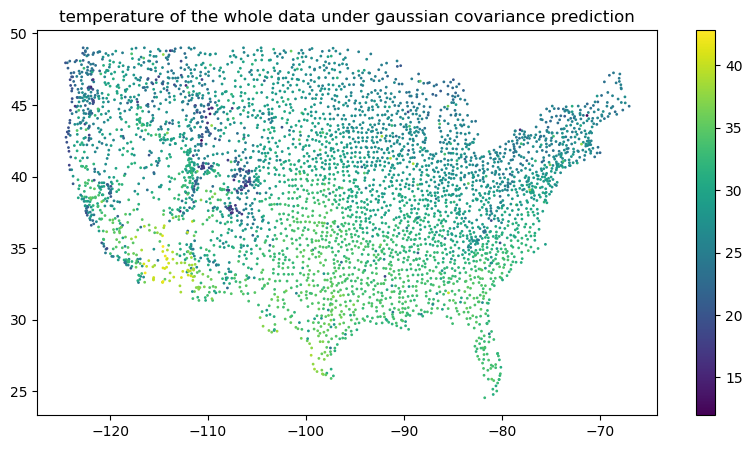

PyObject <matplotlib.colorbar.Colorbar object at 0x145c1f6d8>

In [21]:
df_gau=df
df_gau[Test_sample,4]=Pred_Gau[:,1]

figure(figsize=(10,5))
scatter(df_gau.lon, df_gau.lat, c=df_gau.UStmax.+mean_temp, s=1)
title("temperature of the whole data under gaussian covariance prediction")
colorbar()

### Compared with the previous matern covariance, Gaussian covariance show less accuracy. Because it has larger mean square error. 


We do some testing about our prediction under Gaussian covariance 

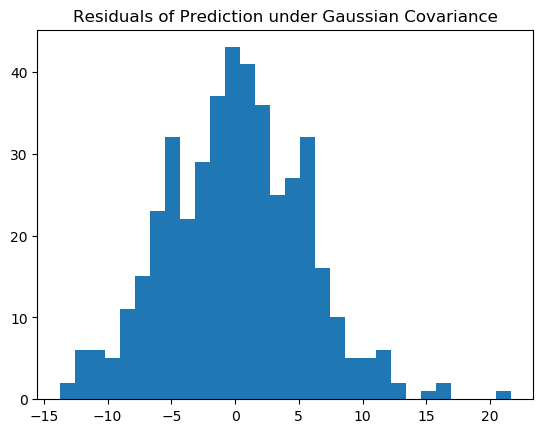

PyObject Text(0.5, 1, 'Residuals of Prediction under Gaussian Covariance')

In [22]:
residuals_gau = Test_data - Pred_Gau
plt.hist(residuals_gau,30)
PyPlot.title("Residuals of Prediction under Gaussian Covariance")

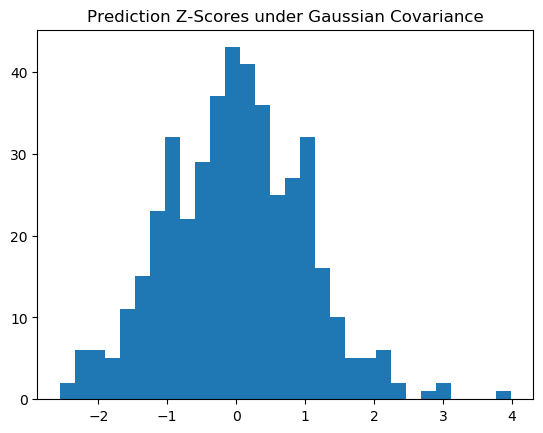

PyObject Text(0.5, 1, 'Prediction Z-Scores under Gaussian Covariance')

In [23]:
plt.hist((residuals_gau.-mean(residuals_gau))./std(residuals_gau),30)
PyPlot.title("Prediction Z-Scores under Gaussian Covariance")

We can see that residuals of Gaussian covariance model have larger deviation and more abnormal points compared with Matern covariance model

### Comments about Gaussian autocovariance model
$\text{Some times when }\rho$ is large(About larger than 1),$ \text{the fitting covariance} \Sigma$ might be negative definite matrix so that it is hard to make some prediction out of it.

And if we choose a smaller $\rho\text{, the covariance matrix }\Sigma$ will be sparse. 

For example for the Gaussian autocovariance function under parameter $\rho=0.1, \sigma=4$ 
 

## Bilinear Interpolation 
### we fix the model using bilinear interpolation 

In [24]:
using PyPlot
using PyCall
scii = pyimport("scipy.interpolate")
nxgrid = 500
nygrid = 500
minimum(Train_Data[:,1])
minimum(Train_Data[:,2])
maximum(Train_Data[:,1])
maximum(Train_Data[:,2])
left_lat = 24.5
right_lat = 49.5
d_lat = (right_lat-left_lat)/nxgrid
left_lon = -125
right_lon = -66.5
d_lon = (right_lon-left_lon)/nygrid

#we build the grid on longtitude and latitude
X = range(left_lat,right_lat,length=nxgrid)  .+ fill(0, nxgrid, nygrid) 
Y = range(left_lon,right_lon,length=nygrid)' .+ fill(0, nxgrid, nygrid) 

griddata = scii.griddata

# Here is the interpolation
fn = griddata((Train_Data[:,1], Train_Data[:,2]), Train_Data[:,4], (X, Y), method="nearest")
fl = griddata((Train_Data[:,1], Train_Data[:,2]), Train_Data[:,4], (X, Y), method="linear")
#fc = griddata((Train_Data[:,1], Train_Data[:,2]), Train_Data[:,4], (X, Y), method="cubic")

#we use the loop function to make the prediction 
#in fact, we just find the nearest grid point for each point
function prediction_bili(axiss::DataFrame)
    pred=zeros(size(axiss,1))
    for i = 1: size(axiss,1)
        pred[i]= fl[ trunc(Int,1+(axiss[i,1]-left_lat)/ d_lat)  , trunc(Int,1+(axiss[i,2]-left_lon)/d_lon ) ]
    end
    return pred
end
Pred_bili= prediction_bili(Test_Data[:,1:2])


440-element Array{Float64,1}:
  5.205646077767183  
  4.303061155494588  
  2.937402224463627  
  4.133474720626494  
  3.9966125699054547 
  4.15709662719723   
  9.060762447975     
  3.3749990366289113 
 11.09661139538686   
  6.992610984607485  
  4.499860821101922  
 -3.163620217355246  
 10.170553060592246  
  ⋮                  
 -3.721202620779739  
  0.07362720677843707
 -7.429764485944062  
 -0.31404464412250727
 -7.095569255817754  
 -2.0470968334474566 
 -4.345480044106543  
  0.9603744566649826 
  0.3345529970943275 
 -0.5740463995382203 
 -5.883336337386862  
 -4.694559464576746  

Numbers of NaN data in bilinear prediction

In [25]:
sum(isnan.(Pred_bili))

1

Because there is some NaN data in bilinear prediction, we need to remove them first to know the average performance of our prediction. 

In [26]:
skipnan(x)= Iterators.filter( !isnan, x ) 
sum(skipnan(skipmissing( Pred_bili-Test_data  )).^2)^(1/2) /sum(skipnan(skipmissing( Test_data - 0*Pred_bili  )).^2)^(1/2)

0.5445594877102222

MSE of prediction under matern covariance 

In [27]:
sum(skipnan(skipmissing( Pred_bili-Test_data  )).^2)/n1

5.044506217452776

### we can also draw the scatter plot of bilinear interpolation

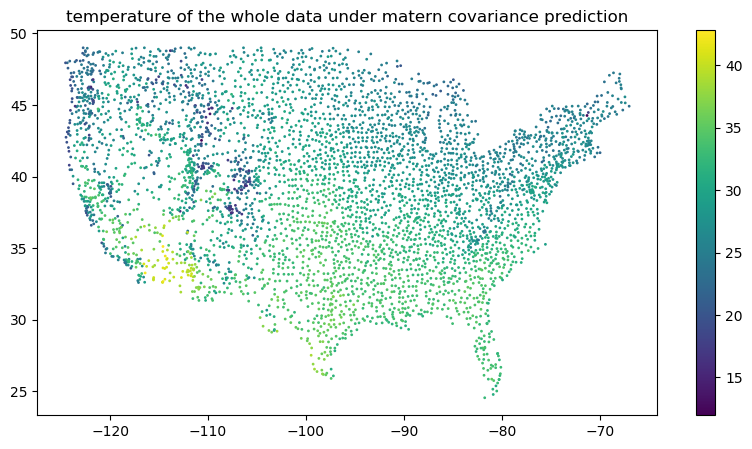

PyObject <matplotlib.colorbar.Colorbar object at 0x1474a9f60>

In [28]:
df_bil=df
df_bil[Test_sample,4]=Pred_bili[:,1]
figure(figsize=(10,5))
scatter(df_bil.lon, df_bil.lat, c=df_bil.UStmax.+mean_temp, s=1)
title("temperature of the whole data under matern covariance prediction")
colorbar()

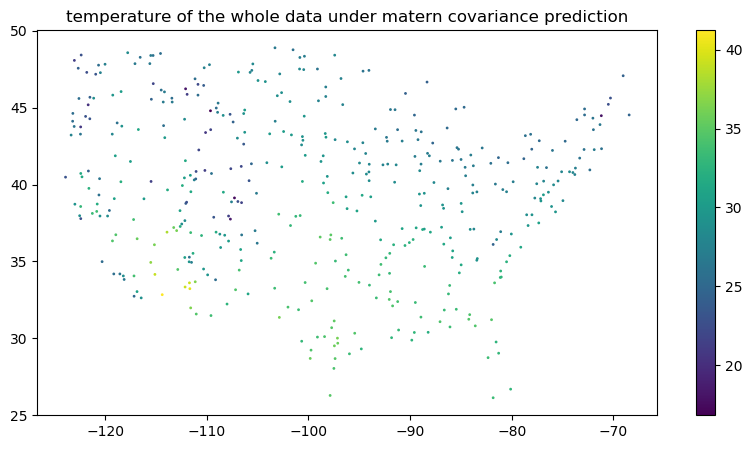

PyObject <matplotlib.colorbar.Colorbar object at 0x1493b7828>

In [29]:
figure(figsize=(10,5))
scatter(df_bil.lon[Test_sample], df_bil.lat[Test_sample], c=df_bil.UStmax[Test_sample].+mean_temp, s=1)
title("temperature of the whole data under matern covariance prediction")
colorbar()

We draw the histogram to do some residual testing  

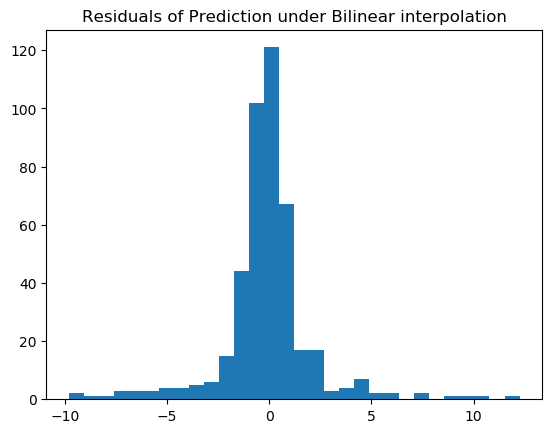

PyObject Text(0.5, 1, 'Residuals of Prediction under Bilinear interpolation')

In [30]:
skipnan(x)= Iterators.filter( !isnan, x ) 
residuals_bili=skipnan(skipmissing( Pred_bili-Test_data  )).*1 
plt.hist(residuals_bili,30)
PyPlot.title("Residuals of Prediction under Bilinear interpolation")

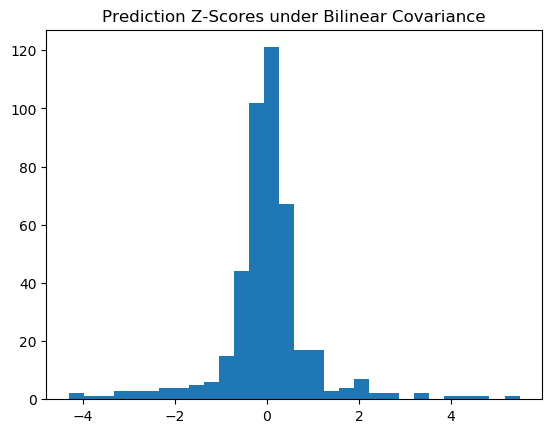

PyObject Text(0.5, 1, 'Prediction Z-Scores under Bilinear Covariance')

In [31]:
hist((residuals_bili.-mean(residuals_bili))./std(residuals_bili),30)
PyPlot.title("Prediction Z-Scores under Bilinear Covariance")

### Some comment about Bilinear interpolation
There will be some NaN for bilinear interpolation. Which means that some of the data points can not be predicted.

The Advantage of Bilinear Interpolation is that it doesn't take much time to select the parameters. As a result, it is quick and efficient way to give a fair prediction.

# SUMMARY :



## we first compare three models
### MSE 
Compare the MSE under three model
$\text{MSE}_{Mat}=6.40$   
$\text{MSE}_{Gau}=29.02$   
        $\text{MSE}_{Bil}=3.07$        
        which means that Bilinear interpolation have the best fit, and Gaussian covariance model have the baddest fit. 


### Residuals
When we do the histogram analysis to the residuals under three different models, we compare them in a row 

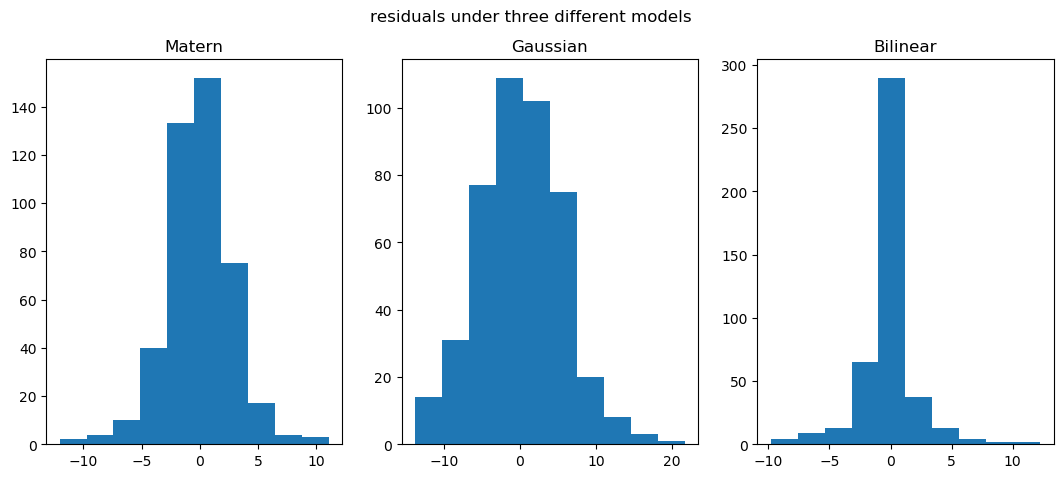

PyObject Text(0.5, 1, 'Bilinear')

In [32]:
fig, ax = subplots(figsize=(13,5),nrows=1, ncols=3)
suptitle("residuals under three different models ")
ax[1,1].hist(residuals_mat,10)
ax[1,1].set_title("Matern")
ax[2,1].hist(residuals_gau,10)
ax[2,1].set_title("Gaussian")
ax[3,1].hist(residuals_bili,10)
ax[3,1].set_title("Bilinear")

From the Residuals under these three models, we can find that Gaussian autocovariance model gave the baddest prediction because of a large sum of prediction data deviates a lot from the true one. 

And we also found that the residuals of Bilinear model shrink much to 0. Which means that most of the points can be fit by bilinear interpolation. However, there are some data that can not be fitted well using bilinear interpolation. Because it does not take the elevation into consideration.

And Matern model give a fair fit for the data. The same problem as bilinear interpolation, it does not take the elevation into consideration. Which might make it deviates a lot in some points.

### Z-Score
We normalized the residuals and draw the Z-score histogram below

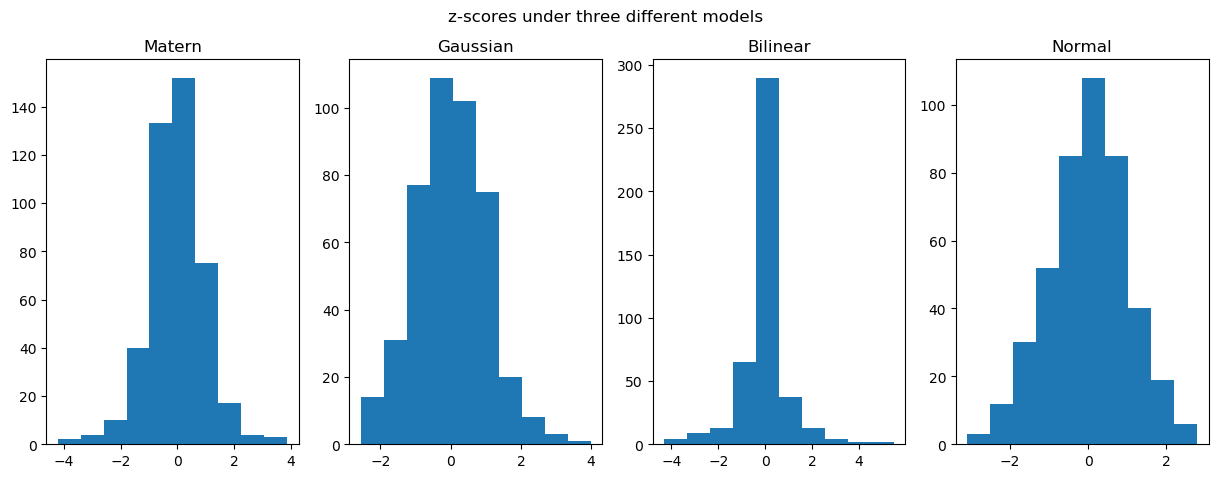

PyObject Text(0.5, 1, 'Normal')

In [33]:

fig, ax = subplots(figsize=(15,5),nrows=1, ncols=4)
suptitle("z-scores under three different models ")
ax[1,1].hist((residuals_mat.-mean(residuals_mat))./std(residuals_mat),10)
ax[1,1].set_title("Matern")
ax[2,1].hist((residuals_gau.-mean(residuals_gau))./std(residuals_gau),10)
ax[2,1].set_title("Gaussian")
ax[3,1].hist((residuals_bili.-mean(residuals_bili))./std(residuals_bili),10)
ax[3,1].set_title("Bilinear")
x=rand(Normal(),n1)
ax[4,1].hist((x.-mean(x))./std(x),10)
ax[4,1].set_title("Normal")

### Scatter Plot

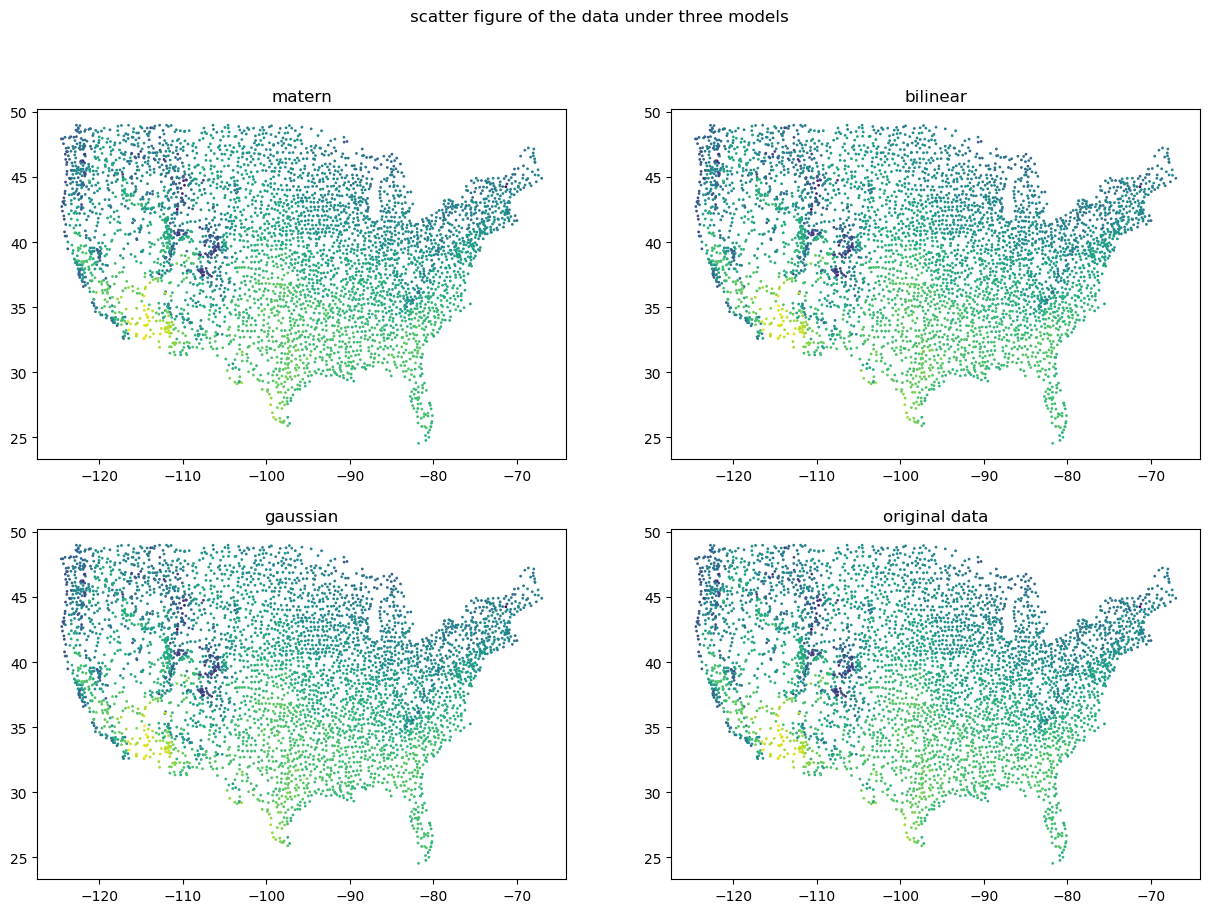

PyObject Text(0.5, 1, 'original data')

In [34]:
fig, ax2 = plt.subplots(figsize=(15,10),nrows=2, ncols=2)
suptitle("scatter figure of the data under three models")
ax2[1,1].scatter(df_mat.lon, df_mat.lat, c = df_mat.UStmax.+mean_temp, s = 1)
h1 = ax2[1,1].set_title("matern")
ax2[2,1].scatter(df_gau.lon, df_gau.lat, c = df_gau.UStmax.+mean_temp, s = 1)
ax2[2,1].set_title("gaussian")
ax2[1,2].scatter(df_bil.lon, df_bil.lat, c = df_bil.UStmax.+mean_temp, s = 1)
ax2[1,2].set_title("bilinear")
ax2[2,2].scatter(df.lon,df.lat,c = df.UStmax,s = 1)
ax2[2,2].set_title("original data")


### Three different models

In a nutshell, Gaussian covariance model gave a poor fit in the prediction. Because the MSE is large and the residuals of prediction show that there are many outliers in the prediction. 

Matern covariance and Bilinear Interpolation gave a fair fit.  Their MSEs are smaller than that of Gaussian. It provides a good fit on most of the data. And the residuals of Bilinear model shrink much to 0, which make the MSE of Bilinear model smaller than that of Matern. 

As for time complexity, both Gaussian covariance and Matern covariance need so much time to choose parameters. However, bilinear interpolation is quick and efficient because it don't need to fit the other tuning parameters to give a prediction 


However, none of these three models take the elevation into account. That is the reason why some of the prediction data deviate a lot from the true values. Maybe we need a good model like kriging to make a better prediction. 






### Numerical issue
When we fit the gaussian covariance, Some times when $\rho$ is large(About larger than 1), the fitting covariance  $\Sigma$ might be negative definite matrix so that it is hard to make some prediction out of it. And if we choose a smaller $\rho\text{, the covariance matrix }\Sigma$ will be sparse. 

There will be some NaN for bilinear interpolation. Which means that some of the data points can not be predicted.

